In [1]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
from ivis import Ivis
import matplotlib.pyplot as plt
from time import perf_counter

## Prepare Dataset

In [2]:
train = pd.read_csv('/workspace/PlayNet/handball_X_train.csv')
train_y = pd.read_csv('/workspace/PlayNet/handball_y_train.csv')
train_states = train_y.copy()
train_states.head()

#play
0  time_out
1  time_out
2  time_out
3  time_out
4  time_out

In [3]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

train_states['#play'] = labelencoder.fit_transform(train_states['#play'])

# passing bridge-types-cat column (label encoded values of bridge_types)
#enc_df = pd.DataFrame(enc.fit_transform(df[['#play']]).toarray())

In [4]:
X = train.values[:train.shape[0], :]
y = train_states.values[:train_states.shape[0], :]

print(X.shape)

(702382, 66)


## Train Model

In [5]:
model = Ivis(n_epochs_without_progress=2, k=50, embedding_dims=30)
embeddings = model.fit(X, y)

Building KNN index


100%|██████████| 702382/702382 [00:03<00:00, 210719.01it/s]


Extracting KNN neighbours


100%|██████████| 702382/702382 [00:19<00:00, 36170.94it/s]


Training neural network
Epoch 1/1000
5488/5488 [==============================] - 15s 2ms/step - loss: 0.3323 - stacked_triplets_loss: 0.1186 - supervised_loss: 0.5459
Epoch 2/1000
5488/5488 [==============================] - 13s 2ms/step - loss: 0.2495 - stacked_triplets_loss: 0.0537 - supervised_loss: 0.4454
Epoch 3/1000
5488/5488 [==============================] - 13s 2ms/step - loss: 0.2276 - stacked_triplets_loss: 0.0443 - supervised_loss: 0.4109
Epoch 4/1000
5488/5488 [==============================] - 13s 2ms/step - loss: 0.2149 - stacked_triplets_loss: 0.0389 - supervised_loss: 0.3909
Epoch 5/1000
5488/5488 [==============================] - 13s 2ms/step - loss: 0.2072 - stacked_triplets_loss: 0.0366 - supervised_loss: 0.3777
Epoch 6/1000
5488/5488 [==============================] - 13s 2ms/step - loss: 0.2011 - stacked_triplets_loss: 0.0342 - supervised_loss: 0.3680
Epoch 7/1000
5488/5488 [==============================] - 13s 2ms/step - loss: 0.1973 - stacked_triplets_loss: 0

In [6]:
embeddings = model.transform(X)

5488/5488 [==============================] - 5s 819us/step


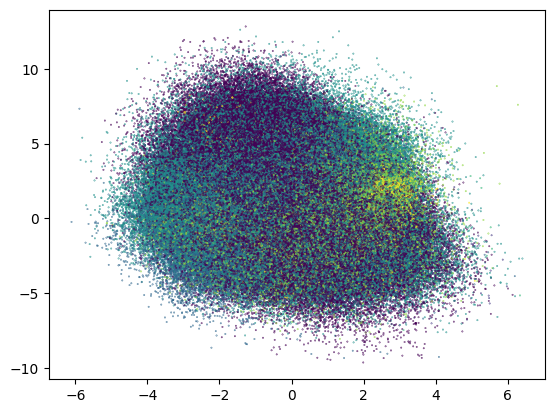

In [7]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=0.1, c=y)

In [27]:
c = ['k_{0}'.format(s) for s in range(30)]

#train_data = pd.read_csv('embedding.csv', header=None, names=c)

label = 'state'
train_data = pd.DataFrame(embeddings)
train_data[label] = train_y['#play']
print(train_data.head())
print(train_data.describe())

time_limit = 60*60*1
metric = 'accuracy'

cst_par = {
    'NN_TORCH': {'num_epochs': 4, 'learning_rate': 0.02, 'epochs_wo_improve': 2},
    'GBM': {'num_boost_round': 10},
    'RF': [        
        {'criterion': 'entropy', 'max_depth': 10, 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}
    ],
    'XT': [
        {'criterion': 'gini', 'max_depth': 12, 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
    ],
    'KNN': {},
}

predictor = TabularPredictor(label, eval_metric=metric).fit(
    train_data, 
    time_limit=time_limit, 
    presets='medium_quality',
    hyperparameters=cst_par
)

          0         1         2         3         4         5         6  \
0  0.793912  1.924736 -4.919260  0.937405  1.569929 -4.607340  1.644559   
1  1.160807 -0.421848 -4.979011  2.516270  4.550895 -3.611637  1.740540   
2  1.712699 -0.719297 -5.114000  2.459801  4.491748 -3.236656  2.575664   
3  1.680070 -0.716469 -4.956800  2.614534  4.510486 -3.197555  2.535154   
4  0.802105 -0.396489 -4.448061  2.204890  4.910276 -3.441251  0.564254   

          7         8         9  ...        21        22        23        24  \
0  0.177538 -0.513380 -8.161077  ...  7.655132 -1.634542 -0.792638 -5.313419   
1  1.779305 -0.159081 -2.837069  ...  8.488281  2.735309 -1.464005 -2.965570   
2  1.102368 -0.158758 -2.034444  ...  9.796777  3.428057 -1.349012 -1.570401   
3  1.091355 -0.107153 -2.073003  ...  9.779944  3.420406 -1.339667 -1.602777   
4  2.478908 -0.120273 -3.484901  ...  6.999600  2.257879 -1.070233 -4.314236   

         25         26        27        28        29     state  
0 -

No path specified. Models will be saved in: "AutogluonModels/ag-20230502_210102/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20230502_210102/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #154-Ubuntu SMP Thu Jan 5 17:03:22 UTC 2023
Train Data Rows:    702382
Train Data Columns: 30
Label Column: state
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	7 unique label values:  ['time_out', 'left_transition', 'left_attack', 'right_transition', 'right_attack', 'left_penal', 'right_penal']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])


                  0              1              2              3   \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean       -0.178441       1.198682       0.295283      -0.180895   
std         1.501154       2.599203       5.776353       5.114780   
min        -6.107221      -9.644949     -15.416127     -16.280092   
25%        -1.222698      -0.550739      -3.968533      -3.723005   
50%        -0.201669       1.186125      -0.275958      -0.489945   
75%         0.859619       2.898069       4.180030       3.075779   
max         6.407684      12.830933      21.726015      22.926680   

                  4              5              6              7   \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean       -0.318996      -0.793857      -0.279013      -0.249756   
std         3.955188       2.045693       4.862860       1.964983   
min       -18.543573     -10.325067     -20.810177      -8.389726   
25%        -2.897298      -2.0807

Train Data Class Count: 7
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    190003.93 MB
	Train Data (Original)  Memory Usage: 84.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 30 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 30 | ['0', '1', '2', '3', '4', ...]
	2.2s = Fit runtime
	30 features in original data used to generate 30 features in processed data.
	Train Data (Processed) Memory Usage: 84.29 MB 

## Test

In [28]:

#test_data = pd.read_csv('embedding_test.csv', header=None, names=c)
#test_data_umap = pd.read_csv('embedding_test_u.csv', header=None, names=c)

test = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')
y_test = pd.read_csv('/workspace/PlayNet/handball_y_test.csv')['#play']

#X = train.values[:train.shape[0], :]
#y = train_states.values[:train_states.shape[0], :]

test_data_ivis = model.transform(test.values)

y_pred = predictor.predict(pd.DataFrame(test_data_ivis))
#y_test = TabularDataset('y_pred_test.csv')

perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, detailed_report=True)

test_df = pd.DataFrame(test_data_ivis)
test_df['state'] = y_test
lead = predictor.leaderboard(test_df, extra_info=True, extra_metrics=['accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted'], silent=True)

lead.to_csv('lead.csv', index=False)

 172/2352 [=>............................] - ETA: 1s

2023-05-02 21:11:44.259231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2352/2352 [==============================] - 2s 871us/step


Evaluation: accuracy on test data: 0.9114948409086379
Evaluations on test data:
{
    "accuracy": 0.9114948409086379,
    "balanced_accuracy": 0.6942838588905993,
    "mcc": 0.8728981149609681
}
Detailed (per-class) classification report:
{
    "left_attack": {
        "precision": 0.9300875404724788,
        "recall": 0.9647689216342934,
        "f1-score": 0.9471108460104172,
        "support": 104510
    },
    "left_penal": {
        "precision": 0.48058252427184467,
        "recall": 0.2764260071798963,
        "f1-score": 0.350974930362117,
        "support": 2507
    },
    "left_transition": {
        "precision": 0.8380713596914176,
        "recall": 0.7554852394033172,
        "f1-score": 0.7946382854216956,
        "support": 28759
    },
    "right_attack": {
        "precision": 0.9309249254092412,
        "recall": 0.9703133405056482,
        "f1-score": 0.9502111232745919,
        "support": 118976
    },
    "right_penal": {
        "precision": 0.3604060913705584,
    

In [29]:
print('\\midrule')

names = {
    'KNeighbors': 'KNN \cite{cover1967nearest}',
    'LightGBM': 'LigthGBM \cite{ke2017lightgbm}',
    'RandomForestEntr': 'RandomForest \cite{ho1995random}',
    'ExtraTreesGini': 'ExtraTrees \cite{geurts2006extremely}',
    'NeuralNetTorch': 'NN \cite{taud2018multilayer}',
    'WeightedEnsemble_L2': 'Ensemble \cite{wolpert1992stacked}'
}

first = True
for m in predictor.get_model_names():
    #print(m)
    y_pred = predictor.predict(pd.DataFrame(test_data_ivis), model=m)

    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, detailed_report=True, silent=True)

    if first:
        print('\\multirow{6}{*}{IVIS  \cite{szubert2019structure}} & ' 
            + names[m] + ' & ' 
            + "{:.1f}".format(round(perf['classification_report']['accuracy']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['recall']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['recall']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['f1-score']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['f1-score']*100,1)) + '\\% \\\\')
        first = False
    else:
        print('\t& ' + names[m] + ' & ' 
            + "{:.1f}".format(round(perf['classification_report']['accuracy']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['recall']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['recall']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['f1-score']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['f1-score']*100,1)) + '\\% \\\\')


\midrule
\multirow{6}{*}{IVIS  \cite{szubert2019structure}} & KNN \cite{cover1967nearest} & 90.5\%  & 90.1\% & 73.8\% & 90.5\% & 69.1\%  & 90.2\% & 71.1\% \\
	& LigthGBM \cite{ke2017lightgbm} & 90.7\%  & 90.4\% & 78.1\% & 90.7\% & 66.8\%  & 90.0\% & 70.9\% \\
	& RandomForest \cite{ho1995random} & 91.6\%  & 91.1\% & 78.4\% & 91.6\% & 68.4\%  & 91.1\% & 71.6\% \\
	& ExtraTrees \cite{geurts2006extremely} & 89.3\%  & 89.3\% & 85.4\% & 89.3\% & 58.4\%  & 88.1\% & 61.9\% \\
	& NN \cite{taud2018multilayer} & 91.1\%  & 90.9\% & 73.3\% & 91.1\% & 71.3\%  & 90.9\% & 71.8\% \\
	& Ensemble \cite{wolpert1992stacked} & 91.1\%  & 90.7\% & 76.0\% & 91.1\% & 69.4\%  & 90.8\% & 72.0\% \\


### Benchmark

In [15]:
test_embed = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')

model.set_params(verbose=0)

time = 0.0
for index, row in test_embed.iterrows():
    #res = model.transform(np.array([row.values,]))
    ivis_start = perf_counter()
    res = model.encoder_(np.array([row.values,]), training=False).numpy()
    ivis_stop = perf_counter()
    time += ivis_stop-ivis_start

In [17]:
print("Elapsed time:", ivis_stop, ivis_start)
print("Tested ", test_embed.shape[0], " elements") 
print("Elapsed time in seconds:", ivis_stop-ivis_start)
print("Perf average per element: ",(time/test_embed.shape[0])*1000, " ms")

Elapsed time: 9004472.516010066 9004472.514016744
Tested  301022  elements
Elapsed time in seconds: 0.0019933227449655533
Perf average per element:  2.0199916148014294  ms


In [9]:
import tensorflow as tf
from tensorflow.compat.v1.profiler import Profiler
print('TensorFlow:', tf.__version__)

forward_pass = tf.function(
    model.encoder_.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model.encoder_.input_shape[1:])])

profiler = Profiler(graph=forward_pass.get_concrete_function().graph)
pro=profiler.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = pro.total_float_ops // 2
print('Flops: {:,}'.format(flops))

TensorFlow: 2.12.0
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Flops: 45,263
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:

In [18]:
avg_time_ivis = (time/test_embed.shape[0])*1000
norm = 16.85 / 1.9074363765962354
norm_ivis = avg_time_ivis * norm

gflops_ivis = flops/(norm_ivis /1000)/1e9

print("IVIS \cite{szubert2019structure} & ", 
      "{:.3f}M".format(round(model.encoder_.count_params()/1e6,3)), 
      " & {:.3f}".format(round(gflops_ivis,3)),
      " & ", 
      "{:.2f}".format(round(norm_ivis,2)),
      " \\\\")

IVIS \cite{szubert2019structure} &  0.045M  & 0.003  &  17.84  \\


In [11]:
print(model.encoder_.count_params())

45470
